In [ ]:
# featurizing composition
from sklearn.impute import SimpleImputer

featurizer = MultipleFeaturizer([
    ElementProperty.from_preset('magpie'),
])

df['composition_obj'] = df['composition'].apply(str_to_composition)
feature_df = featurizer.featurize_dataframe(df, 'composition_obj', ignore_errors=True)

# keeping numeric features only
X_raw = feature_df.select_dtypes(include=[np.number])
X_raw = X_raw.replace([np.inf, -np.inf], np.nan)
X_raw = X_raw.dropna(axis=1, how='all')  # Remove all-NaN columns

# imputing missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X_raw)
y = df['gap expt'].values

/usr/local/lib/python3.11/dist-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


MultipleFeaturizer:   0%|          | 0/6354 [00:00<?, ?it/s]

In [ ]:
print('Feature matrix:', X.shape)
metals = y < 0.1

Feature matrix: (6354, 133)


In [ ]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)

In [ ]:
# SVC -> SVR
X_train, X_test, y_train, y_test, m_train, m_test = train_test_split(
    X_scaled, y, metals, test_size=0.15, stratify=metals, random_state=SEED)

svc = SVC(class_weight='balanced', kernel='rbf', C=10, gamma=0.01, probability=True, random_state=SEED)
svc.fit(X_train, m_train)

# only training SVR on non-metals
svr = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.1)
svr.fit(X_train[~m_train], y_train[~m_train])

m_pred = svc.predict(X_test)
preds = np.where(m_pred, 0.0, svr.predict(X_test))

mae = mean_absolute_error(y_test, preds)
rmse = root_mean_squared_error(y_test, preds)
print(f"SVC→SVR  MAE = {mae:.3f} eV  RMSE = {rmse:.3f} eV")


SVC→SVR  MAE = 0.055 eV  RMSE = 0.124 eV


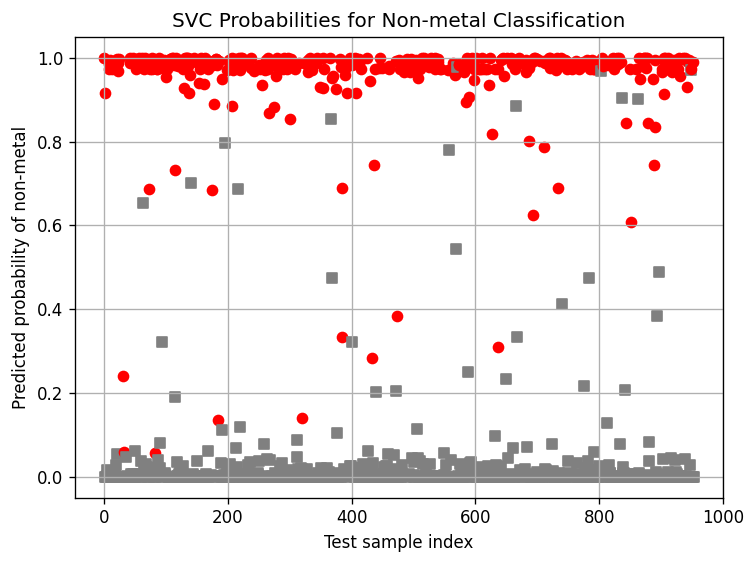

In [ ]:
probs = svc.predict_proba(X_test)[:, 1]

# Scatter plot: red for non-metals, gray for metals
plt.figure()
for i in range(len(probs)):
    color = 'red' if m_test[i] else 'gray'
    marker = 'o' if m_test[i] else 's'
    plt.scatter(i, probs[i], color=color, marker=marker)
plt.xlabel('Test sample index')
plt.ylabel('Predicted probability of non-metal')
plt.title('SVC Probabilities for Non-metal Classification')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
accuracy = accuracy_score(m_test, m_pred)
print(f"SVC Accuracy: {accuracy:.2f}")

SVC Accuracy: 0.98


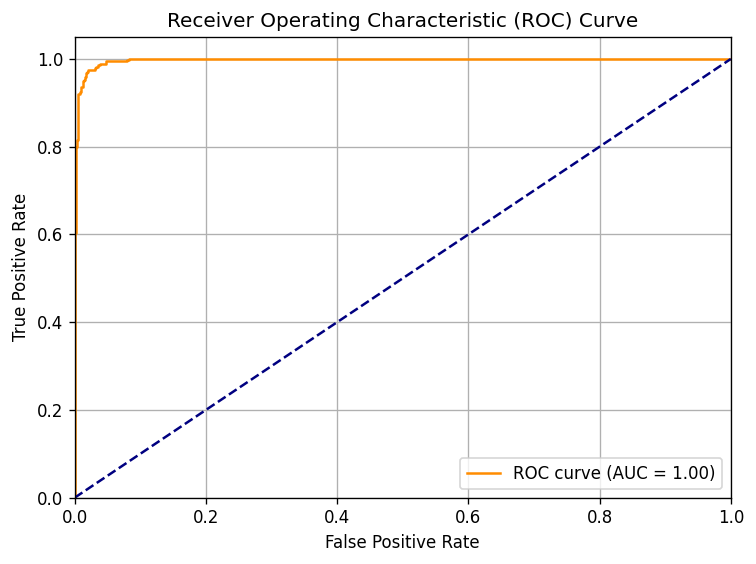

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(m_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

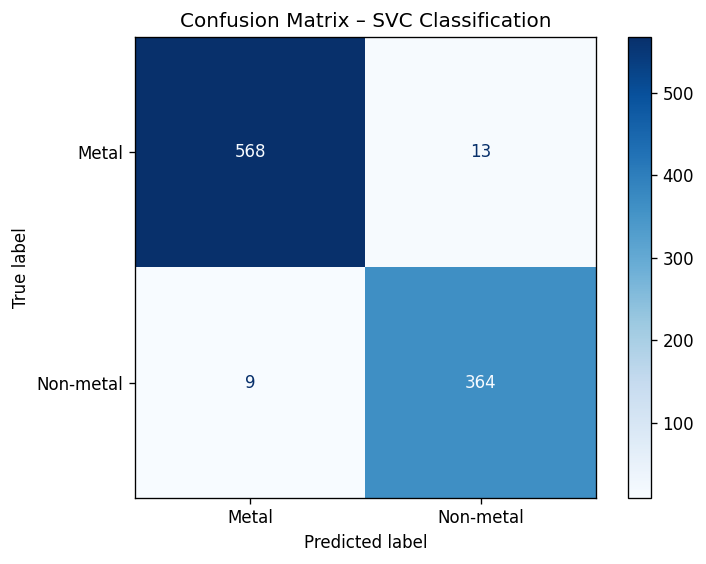

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(m_test, m_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Metal", "Non-metal"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix – SVC Classification")
plt.grid(False)
plt.tight_layout()
plt.show()

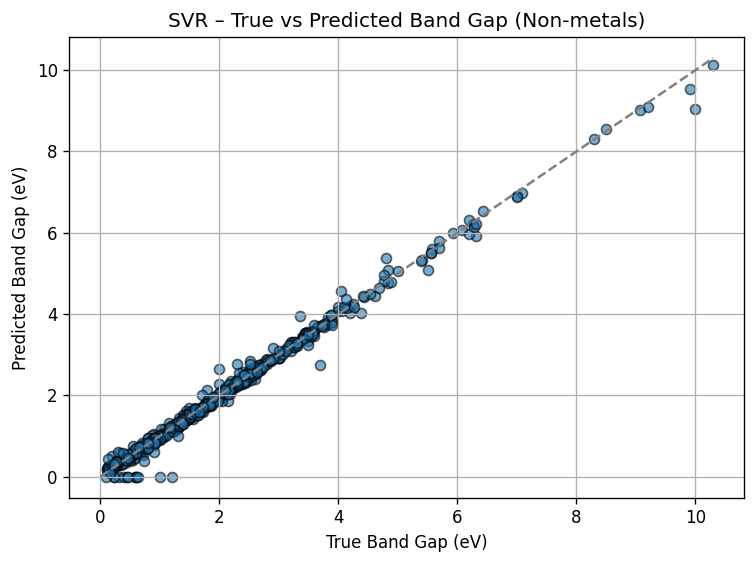

In [ ]:
true_nonmetals = y_test[~m_test]
pred_nonmetals = preds[~m_test]

plt.figure()
plt.scatter(true_nonmetals, pred_nonmetals, alpha=0.6, edgecolor='k')
plt.plot([0, max(true_nonmetals)], [0, max(true_nonmetals)], '--', color='gray')
plt.xlabel('True Band Gap (eV)')
plt.ylabel('Predicted Band Gap (eV)')
plt.title('SVR – True vs Predicted Band Gap (Non-metals)')
plt.grid(True)
plt.tight_layout()
plt.show()

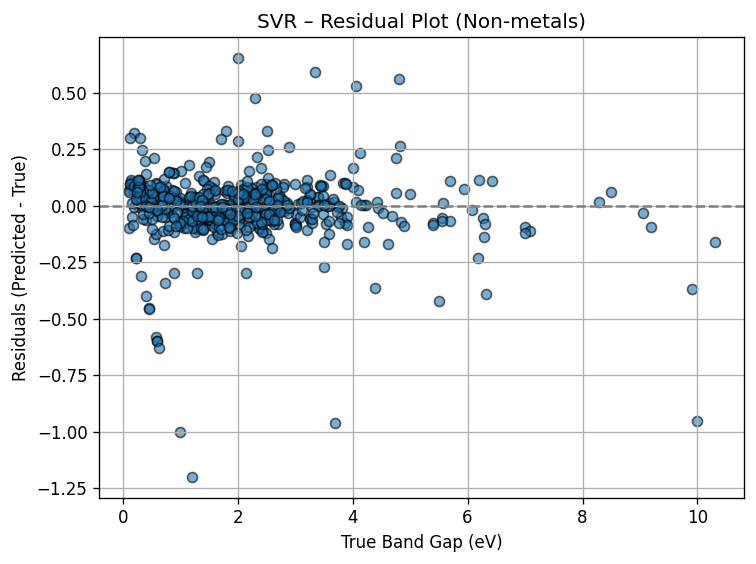

In [ ]:
residuals = pred_nonmetals - true_nonmetals

plt.figure()
plt.scatter(true_nonmetals, residuals, alpha=0.6, edgecolor='k')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('True Band Gap (eV)')
plt.ylabel('Residuals (Predicted - True)')
plt.title('SVR – Residual Plot (Non-metals)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
mae = mean_absolute_error(true_nonmetals, pred_nonmetals)
rmse = root_mean_squared_error(true_nonmetals, pred_nonmetals)
print(f'SVR Performance on Non-metals\nMAE = {mae:.3f} eV | RMSE = {rmse:.3f} eV')

SVR Performance on Non-metals
MAE = 0.084 eV | RMSE = 0.149 eV
